<a href="https://colab.research.google.com/github/pierreduke/Rice_Leaf_Disease-DIP-ET4591-20202/blob/main/DenseNet121.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!unzip /content/drive/MyDrive/Rice.zip

Archive:  /content/drive/MyDrive/Rice.zip
   creating: Rot_Img/
   creating: Rot_Img/test/
   creating: Rot_Img/test/Bacterial leaf blight/
  inflating: Rot_Img/test/Bacterial leaf blight/Bacterial115.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/Bacterial116.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/Bacterial117.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/Bacterial118.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/Bacterial119.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/Bacterial120.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/Bacterial24.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/Bacterial25.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/Bacterial26.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/Bacterial27.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/Bacterial56.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/rice_0_1165.jpg  
  inflating: Rot_Img/test/Bacterial leaf blight/rice_0_1172.jp

**1) Khai báo thư viện**

In [3]:
#Khai bao thu vien
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers.core import Dropout
from imutils import paths
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Flatten
from google.colab.patches import cv2_imshow
from keras.models import load_model
import matplotlib.pyplot as plt
import numpy as np
import pickle
import cv2
import os

**2) Khởi tạo model**

*2.1) DenseNet*

In [4]:
#Model_DenseNet121
from tensorflow.keras.applications import DenseNet121
baseModel = DenseNet121(weights="imagenet", include_top=False, input_tensor=Input(shape=(64, 64, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2,2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(3, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
print(model.summary())

29089792/29084464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 70, 70, 3)    0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
_____________________________

*2.2) VGG16*

In [5]:
# # Model VGG16
# from tensorflow.keras.applications import VGG16
# baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(64, 64, 3)))
# headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(2,2))(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(1024, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(1024, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(3, activation="softmax")(headModel)
# model = Model(inputs=baseModel.input, outputs=headModel)
# print(model.summary())

*2.3) MobileNet*

In [6]:
# #Model MobileNet
# from tensorflow.keras.applications import MobileNet
# baseModel = MobileNet(weights="imagenet", include_top=False, input_tensor=Input(shape=(64, 64, 3)))
# headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(2,2))(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(1024, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(1024, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(3, activation="softmax")(headModel)
# model = Model(inputs=baseModel.input, outputs=headModel)
# print(model.summary())

*2.4) InceptionV3*

In [7]:
# #Model Inception
# from tensorflow.keras.applications import InceptionV3
# baseModel = InceptionV3(weights="imagenet", include_top=False, input_tensor=Input(shape=(76, 76, 3)))
# headModel = baseModel.output
# headModel = AveragePooling2D(pool_size=(1,1))(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(1024, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(1024, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(3, activation="softmax")(headModel)
# model = Model(inputs=baseModel.input, outputs=headModel)
# print(model.summary())

**3) Thiết lập LR, Batch_size, Epochs**

In [8]:
#thiet lap thong so lr, batch_size va epochs
INIT_LR = 1e-5
BS = 8
EPOCHS = 20

**4) Khởi tạo ảnh đầu vào**

In [9]:
#khoi tao input
imagePaths = list(paths.list_images('/content/Rot_Img/train'))
data = []
labels = []

for imagePath in imagePaths:
    label = imagePath.split(os.path.sep)[-2]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (64,64))
    # cv2_imshow(image)
    data.append(image)
    labels.append(label)
data = np.array(data, dtype="float") / 255.0

**5) Mã hoá one-hot nhãn**

In [10]:
#one-hot label
le = LabelEncoder()
labels = le.fit_transform(labels)
labels = np_utils.to_categorical(labels, 3)

**6) Thiết lập dữ liệu train**

In [11]:
#set du lieu train
(X_train, X_val, y_train, y_val) = train_test_split(data, labels, test_size=0.1, random_state=42)

**7) Compile và train model**

In [12]:
#compile + train
opt = Adam(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])
H = model.fit(X_train, y_train, validation_data=(X_val, y_val), batch_size=BS, steps_per_epoch=len(X_train) // BS, epochs=EPOCHS)

Epoch 1/20
282/282 [==============================] - 58s 59ms/step - loss: 0.9982 - accuracy: 0.4885 - val_loss: 0.7869 - val_accuracy: 0.6468
Epoch 2/20
282/282 [==============================] - 16s 51ms/step - loss: 0.7222 - accuracy: 0.7037 - val_loss: 0.5380 - val_accuracy: 0.7659
Epoch 3/20
282/282 [==============================] - 14s 51ms/step - loss: 0.5694 - accuracy: 0.7734 - val_loss: 0.4123 - val_accuracy: 0.8373
Epoch 4/20
282/282 [==============================] - 14s 51ms/step - loss: 0.4675 - accuracy: 0.8272 - val_loss: 0.3224 - val_accuracy: 0.8651
Epoch 5/20
282/282 [==============================] - 14s 51ms/step - loss: 0.4231 - accuracy: 0.8383 - val_loss: 0.2865 - val_accuracy: 0.9008
Epoch 6/20
282/282 [==============================] - 14s 50ms/step - loss: 0.3467 - accuracy: 0.8774 - val_loss: 0.2659 - val_accuracy: 0.9008
Epoch 7/20
282/282 [==============================] - 14s 51ms/step - loss: 0.2977 - accuracy: 0.8898 - val_loss: 0.2280 - val_accuracy:

**8) Đồ thị**

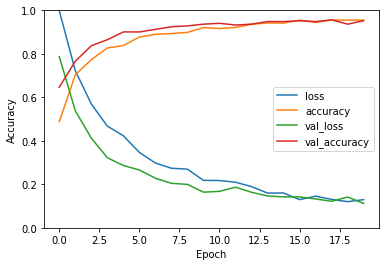

In [14]:
#do thi
import matplotlib.pyplot as plt

plt.plot(np.arange(0, EPOCHS), H.history['loss'], label='loss')
plt.plot(np.arange(0, EPOCHS), H.history['accuracy'], label = 'accuracy')
plt.plot(np.arange(0, EPOCHS), H.history['val_loss'], label='val_loss')
plt.plot(np.arange(0, EPOCHS), H.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend()
plt.show()

**9) Lưu model**

In [24]:
#save model
model.save('DIP_DenseNet121.h5')

**NGẮT**

---



---



**1) Load model đã train**

In [ ]:
from keras.models import load_model

# model1 = load_model('/content/drive/MyDrive/ImgProc/XLA_DenseNet121.h5')



---



---

**TEST**


---



---



**1) Khai báo thư viện**

In [15]:
#Khai bao thu vien
from sklearn.preprocessing import LabelEncoder
from keras.optimizers import Adam
from keras.utils import np_utils
from keras.layers.core import Dropout
from imutils import paths
from google.colab.patches import cv2_imshow
from keras.models import load_model
import numpy as np
import pickle
import cv2
import os

**2) Khởi tạo dữ liệu test + One-hot nhãn**

In [16]:
#Khoi tao du lieu test
imagePaths_test = list(paths.list_images('/content/Rot_Img/test'))
data_test = []
labels_test = []
for path_test in imagePaths_test:
    label2 = path_test.split(os.path.sep)[-2]
    image2 = cv2.imread(path_test)
    image2 = cv2.resize(image2, (64, 64))
    data_test.append(image2)
    labels_test.append(label2)
data_test = np.array(data_test, dtype="float") / 255.0

#one-hot label
le_test = LabelEncoder()
labels_test = le_test.fit_transform(labels_test)
labels_test = np_utils.to_categorical(labels_test, 3)

**3) Thiết lập dữ liệu test**

In [17]:
#set du lieu test
X_test = data_test
y_test = labels_test

**4) Đánh giá tệp test**

In [18]:
score_test = model.evaluate(X_test, y_test)
print('Score test = ', score_test)

9/9 [==============================] - 2s 107ms/step - loss: 0.1689 - accuracy: 0.9185
Score test =  [0.16886314749717712, 0.9185185432434082]


**6) Bảng thống kê các giá trị phân loại**


> Accuracy = (TP+TN)/(TP+FP+FN+TN)

> Precision = TP/(TP+FP)

> Recall = TP/(TP+FN)

> F1 Score = 2(Recall * Precision) / (Recall + Precision)

















In [20]:
y_pred_test = model.predict(X_test)
from sklearn.metrics import classification_report
print(classification_report(y_test.argmax(axis=1), y_pred_test.argmax(axis=1), target_names=le_test.classes_, digits = 5))

                       precision    recall  f1-score   support

Bacterial leaf blight    0.96629   0.95556   0.96089        90
           Brown spot    0.91011   0.90000   0.90503        90
            Leaf smut    0.88043   0.90000   0.89011        90

             accuracy                        0.91852       270
            macro avg    0.91895   0.91852   0.91868       270
         weighted avg    0.91895   0.91852   0.91868       270



In [21]:
print("So sanh test")
testY = np.argmax(y_test, axis=1).ravel()
predtestY = np.argmax(y_pred_test, axis=1).ravel()
# print(np.argmax(y_test, axis = 1))
print(testY)
print(predtestY)

So sanh test
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 1 2 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 2 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 2 1 1 1 1 2 1 1 1 1 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 1 1 2 0 2 2 2 2 2 2 

In [22]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(testY, predtestY)
print(cnf_matrix)

[[86  2  2]
 [ 0 81  9]
 [ 3  6 81]]


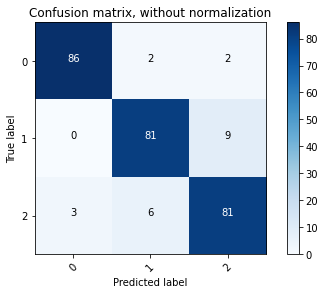

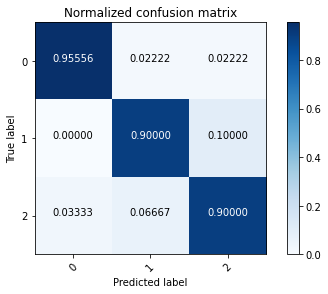

In [23]:
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
class_names = [0, 1, 2]
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()